In [1]:
import sys
sys.path.append('..')
import h5py
import yaml
import jax
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation,my_discrete_cmap
from flowrec.utils.py_helper import slice_from_tuple
from flowrec.utils.system import set_gpu
set_gpu(0,0.5)

# Get summary file

In [13]:
x_base = 132
triangle_base_coords = [49,80]
data_dir = Path('../local_data/re100/')
(ux,uy,pp) = simulation.read_data_2dtriangle(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
slice_to_keep = ((None,), (None,), (None,250,None), (None,))
s = slice_from_tuple(slice_to_keep)
x = x[s]
[x_train,_,_], _ = data_utils.data_partition(x,
    1,
    (600,100,100),
    REMOVE_MEAN=False,
    SHUFFLE=False
) # Do not shuffle, do not remove mean for training with physics informed loss
[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
pb_train = simulation.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
pb_train = np.reshape(pb_train,(600,-1))
datainfo = data_utils.DataMetadata(
    re = 100.0,
    discretisation=[0.125,12./512.,4./128.],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()
rng = jax.random.PRNGKey(10)
u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)

result_dir = Path('../testresult')
def create_summary_file(result_dir: Path):
    if Path(result_dir,'summary.h5').exists():
        raise ValueError('summary file already exist')
    
    folder_list = [_d for _d in result_dir.iterdir() if _d.is_dir()]
    counter = 0
    ## for each run in the sweep, get summary
    summary_loss = []
    summary_name = []

    for d in folder_list:
        summary_name.append(str(d.name))
        counter = counter + 1
        print(counter, d.name)

        with open(Path(d,'config.yml'),'r') as f:
            cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
        
        take_observation, _ = cfg.case.observe(
            cfg.data_config, 
            example_pred_snapshot=u_train[0,...],
            example_pin_snapshot=pb_train[0,...],
        )
        _, train_minmax = take_observation(u_train, init=True) # observed_train is normalised if data_config.normalise is True
        state = state_utils.restore_trainingstate(d,'state')
        prep_data, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
        mdl = make_model(cfg.model_config)

        if cfg.data_config.normalise:
            [pb_train_normalised], _ = data_utils.normalise(pb_train,range=[train_minmax[-1]])
            pb_train_batch = np.array_split(pb_train_normalised,2,0)
        else:
            pb_train_batch = np.array_split(pb_train,2,0)
        
        pred_train = []
        for inn in pb_train_batch:
            pred_train.append(mdl.apply(state.params,rng,inn,TRAINING=False))
        pred_train = np.concatenate(pred_train)
        if cfg.data_config.normalise: # the input to the network is normalised is normalise=True
            pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
        observed_pred = take_observation(pred_train)
        observed_train = take_observation(u_train)

        loss = np.array([
            losses.relative_error(pred_train, u_train),
            losses.divergence(pred_train[...,:-1], datainfo),
            losses.momentum_loss(pred_train, datainfo),
            losses.mse(observed_pred, observed_train),
        ])
        summary_loss.append(loss)
        print(loss[0])
    
    summary_loss = np.array(summary_loss)
    with h5py.File(Path(result_dir,'summary.h5'),'w') as hf:
        hf.create_dataset('runs_name',data=list(summary_name),dtype=h5py.string_dtype(encoding='utf-8'))
        hf.create_dataset('runs_loss',data=summary_loss)

In [17]:
# create_summary_file(Path("../local_results/2dtriangle/sweep_loss_classic_fc2branch/"))
# create_summary_file(Path("../local_results/2dtriangle/sweep_loss_3_fc2branch/"))

1 bright-sweep-25
0.448722
1 giddy-sweep-19
0.468006
1 sleek-sweep-21
0.22305188
1 frosty-sweep-5
0.45178306
1 dutiful-sweep-17
0.4924179
1 still-sweep-9
0.508957
1 splendid-sweep-31
0.07084018
1 youthful-sweep-29
0.4377253
1 visionary-sweep-15
0.48900452
1 likely-sweep-4
0.04135274
1 faithful-sweep-13
0.054722942
1 spring-sweep-9
0.040232923
1 silvery-sweep-27
0.5029934
1 fragrant-sweep-30
0.44149554
1 splendid-sweep-10
0.4389203
1 blooming-sweep-7
0.40697607
1 celestial-sweep-20
0.41309085
1 youthful-sweep-1
0.98069185
1 denim-sweep-10
0.081850894
1 quiet-sweep-26
0.50912267
1 lyric-sweep-22
0.50705796
1 dutiful-sweep-2
0.037944563
1 true-sweep-16
0.4138328
1 different-sweep-5
0.46864688
1 distinctive-sweep-12
0.44631508
1 effortless-sweep-6
0.071774304
1 peach-sweep-4
0.7469118
1 hardy-sweep-28
0.5073621
1 pious-sweep-24
0.08922897
1 colorful-sweep-11
0.43376595
1 efficient-sweep-10
0.52046555
1 eternal-sweep-23
0.60123813
1 zesty-sweep-6
0.54022205
1 avid-sweep-3
0.03949596
1 galla

Load runs summary

In [18]:
sweep_dir_3 = Path('../local_results/2dtriangle/sweep_loss_3_fc2branch')
with h5py.File(Path(sweep_dir_3,'summary.h5'),'r') as hf:
    name_3 = np.array(hf.get('runs_name')).astype('unicode')
    loss_3 = np.array(hf.get('runs_loss')) # [rel_l2, div, momemtum, sensors]


In [19]:
sweep_dir_classic = Path('../local_results/2dtriangle/sweep_loss_classic_fc2branch')
with h5py.File(Path(sweep_dir_classic,'summary.h5'),'r') as hf:
    name_classic = np.array(hf.get('runs_name')).astype('unicode')
    loss_classic = np.array(hf.get('runs_loss')) # [rel_l2, div, momemtum, sensors]


plot statistics

In [20]:
loss_3_p = np.concatenate((loss_3[:,[0]],np.sum(loss_3[:,[1,2]],axis=-1,keepdims=True),loss_3[:,[-1]]),axis=-1)
loss_classic_p = np.concatenate((loss_classic[:,[0]],np.sum(loss_classic[:,[1,2]],axis=-1,keepdims=True),loss_classic[:,[-1]]),axis=-1)

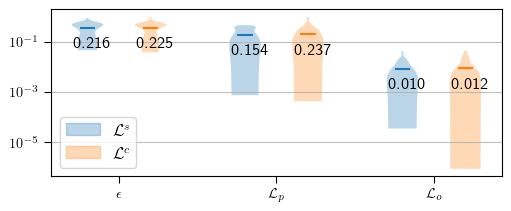

In [59]:
mean3 = np.mean(loss_3_p,axis=0)
std3 = np.std(loss_3_p,axis=0)
meanclassic = np.mean(loss_classic_p,axis=0)
stdclassic = np.std(loss_classic_p,axis=0)

fig,ax = plt.subplots(1,1,figsize=(5,2))
p3 = np.array([1.,2.,3.])-0.2
pc = np.array([1.,2.,3.])+0.2
ax.set(yscale='log',xticks=[1,2,3],xticklabels=['$\epsilon$','$\mathcal{L}_p$','$\mathcal{L}_o$'])
violin1 = ax.violinplot(loss_3_p,positions=p3,widths=0.2,showextrema=False,showmeans=True)
violin2 = ax.violinplot(loss_classic_p,positions=pc,widths=0.2,showextrema=False,showmeans=True)
ax.grid(axis='y')

labels = []
color = violin1["bodies"][0].get_facecolor().flatten()
labels.append((matplotlib.patches.Patch(color=color), '$\mathcal{L}^s$'))
color = violin2["bodies"][0].get_facecolor().flatten()
labels.append((matplotlib.patches.Patch(color=color), '$\mathcal{L}^c$'))

for i in range(3):
    ax.text(p3[i]-0.09,mean3[i]-mean3[i]/1.2,"{:.3f}".format(std3[i]))
    ax.text(pc[i]-0.09,mean3[i]-mean3[i]/1.2,"{:.3f}".format(stdclassic[i]))

plt.legend(*zip(*labels),loc=3)
# plt.savefig('./figs/clean_compare_lossfn')
plt.show()

In [57]:
print(np.count_nonzero(loss_3[:,0]<0.1)/len(name_3))
print(np.count_nonzero(loss_classic[:,0]<0.1)/len(name_classic))

0.275
0.2894736842105263
dutiful-sweep-2 0.037944563
fine-sweep-3 0.04628248


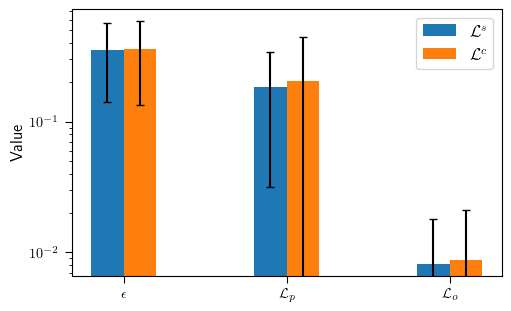

[0.21615177 0.15358843 0.00986118] [0.22483642 0.23669127 0.012127  ]


In [63]:

plt.figure(figsize=(5,3))
# plt.grid(axis='y')
plt.bar([0.9,1.9,2.9],mean3,width=0.2,yerr=std3,label='$\mathcal{L}^s$')
plt.bar([1.1,2.1,3.1],meanclassic,width=0.2,yerr=stdclassic,label='$\mathcal{L}^c$')
plt.yscale('log')
plt.ylabel('Value')
plt.legend()
plt.xticks(ticks=[1,2,3],labels=['$\epsilon$', '$\mathcal{L}_p$','$\mathcal{L}_o$'])
# plt.savefig('./figs/clean_compare_lossfn')
plt.show()
print(std3, stdclassic)

In [64]:
l_3_total = np.sum(loss_3[:,1:],axis=-1)
l_classic_total = np.sum(loss_classic[:,1:],axis=-1)
l_3_physics = loss_3_p[:,1]
l_classic_physics = loss_classic_p[:,1]

# correlation coefficients
corr3 = np.corrcoef(l_3_total,loss_3_p[:,0])
corrclassic = np.corrcoef(l_classic_total,loss_classic_p[:,0])


idx_c = np.argmin(l_classic_total)
print(name_classic[idx_c], l_classic_total[idx_c], loss_classic[:,0][idx_c])
idx_c = np.argmin(l_3_total)
print(name_3[idx_c], l_3_total[idx_c], loss_3[:,0][idx_c])

dutiful-sweep-2 0.00043321087 0.037944563
fine-sweep-3 0.0007783653 0.04628248


/tmp/ipykernel_265877/2510290640.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set(xlim=[0,1],ylim=[0,1])
/tmp/ipykernel_265877/2510290640.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set(xlim=[0,1],ylim=[0,1])


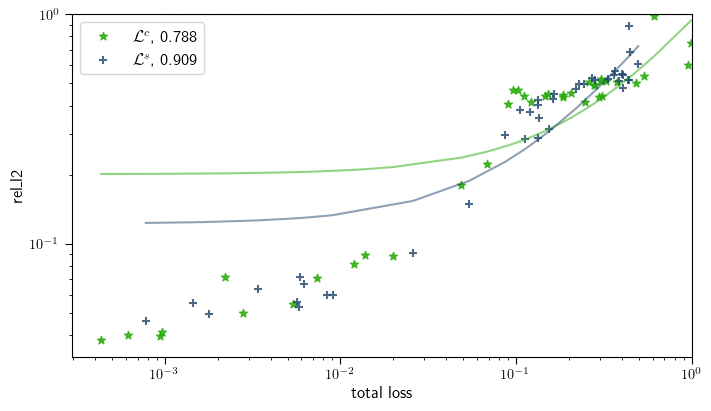

In [62]:
fig, ax = plt.subplots(1,1)

ax.scatter(l_3_total,loss_3[:,0],color=my_discrete_cmap(0),label='$\mathcal{L}^s$, '+f'{corr3[0,1]:.3f}',marker='+',alpha=0.8)
ax.scatter(l_classic_total,loss_classic[:,0],color=my_discrete_cmap(2),label='$\mathcal{L}^c$, '+ f'{corrclassic[0,1]:.3f}',marker='*',alpha=0.8)

# line of best fit
plt.plot(np.unique(l_classic_total), np.poly1d(np.polyfit(l_classic_total, loss_classic[:,0], 1))(np.unique(l_classic_total)),color=my_discrete_cmap(2),alpha=0.5)
plt.plot(np.unique(l_3_total), np.poly1d(np.polyfit(l_3_total, loss_3[:,0], 1))(np.unique(l_3_total)),color=my_discrete_cmap(0),alpha=0.5)

ax.set(yscale='log',xscale='log')
ax.set(xlim=[0,1],ylim=[0,1])
ax.legend(loc='upper left')
ax.set_xlabel('total loss')
ax.set_ylabel('rel_l2')
ax.hlines(1.0,xmin=0.001,xmax=1,color='k',linestyles='--')

plt.show()

# Verify results
Verify that the 'good' ones are good and 'bad' ones are bad

1. Compare robustness with respect to the range of hyperparameters

In [126]:
import matplotlib.backends.backend_pdf

Load data and model for evaluation

In [124]:
# temp_results_dir = Path('../local_results/2dtriangle/sweep_loss_3_fc2branch/leafy-sweep-7')
# with open(Path(temp_results_dir,'config.yml'),'r') as f:
#     cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
#     cfg.data_config.data_dir = '.'+cfg.data_config.data_dir

# x_base = 132
# triangle_base_coords = [49,80]
# (ux,uy,pp) = simulation.read_data_2dtriangle(cfg.data_config.data_dir,x_base)
# x = np.stack([ux,uy,pp],axis=0)
# # remove parts where uz is not zero
# s = slice_from_tuple(cfg.data_config.slice_to_keep)
# x = x[s]

# [x_train,x_val,x_test], _ = data_utils.data_partition(x,
#     1,
#     cfg.data_config.train_test_split,
#     REMOVE_MEAN=cfg.data_config.remove_mean,
#     SHUFFLE=cfg.data_config.shuffle
# ) # Do not shuffle, do not remove mean for training with physics informed loss

# [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
# [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
# [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

# datainfo = data_utils.DataMetadata(
#     re = cfg.data_config.re,
#     discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
#     axis_index=[0,1,2],
#     problem_2d=True
# ).to_named_tuple()


/tmp/ipykernel_222714/4159717746.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,3,figsize=(8,3))


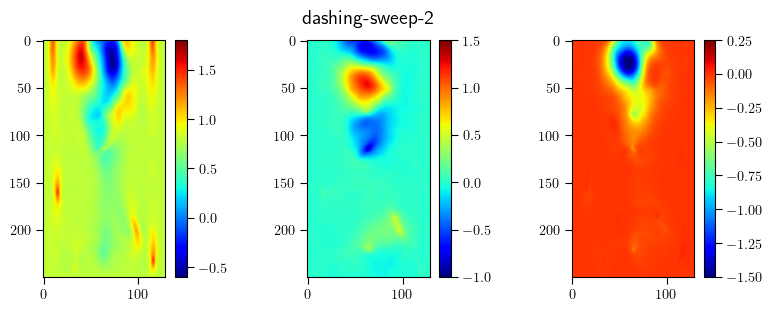

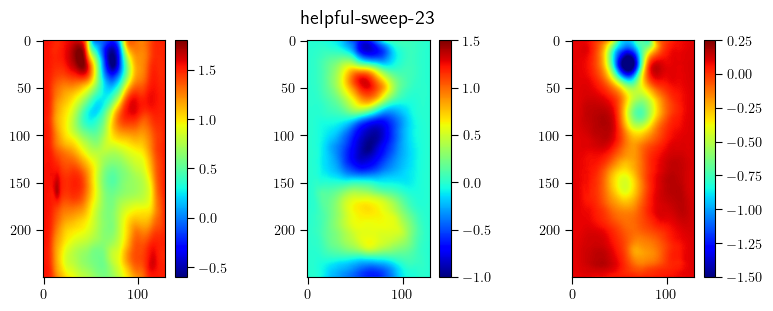

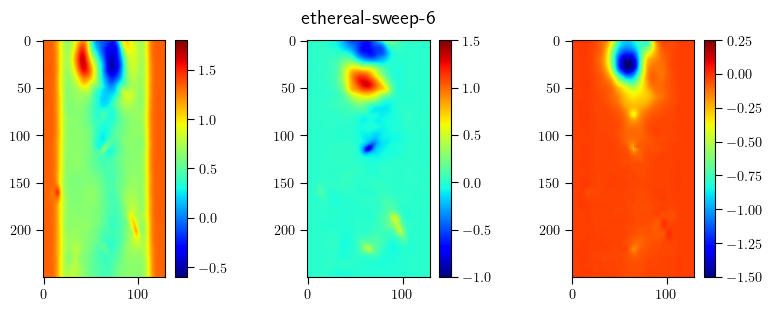

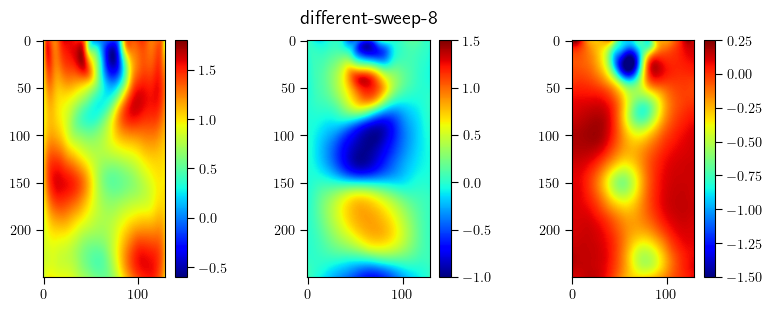

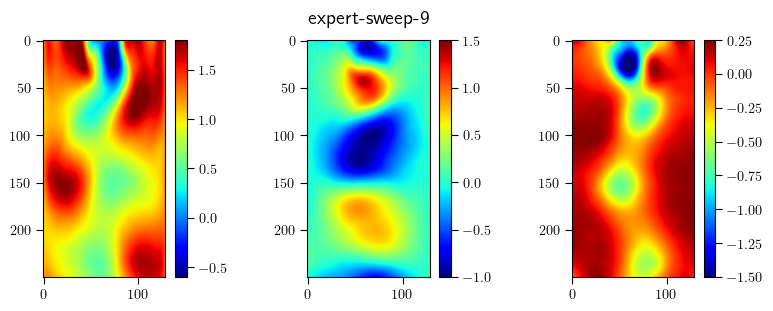

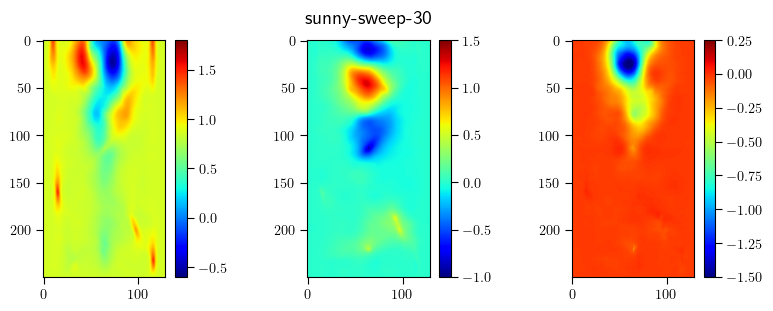

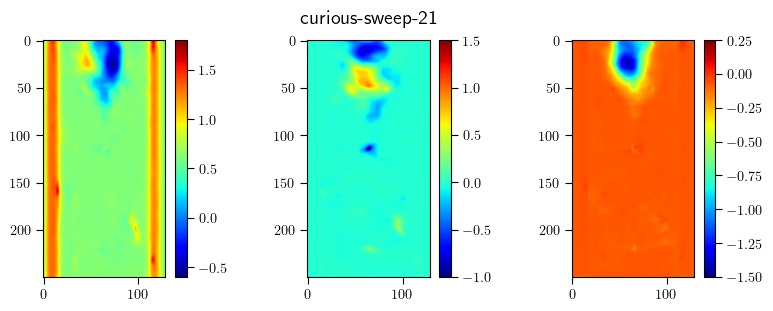

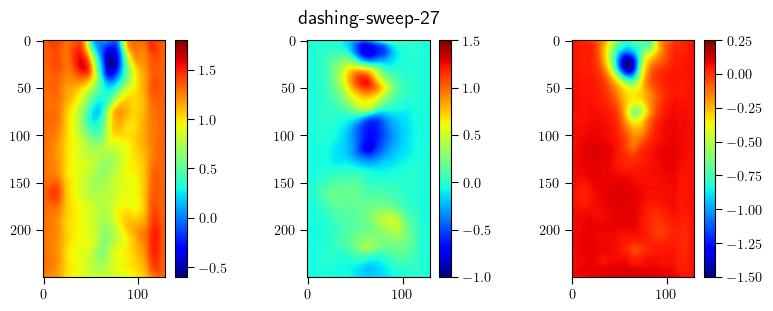

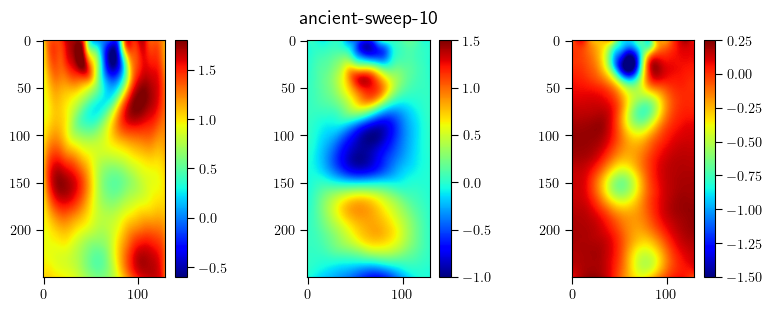

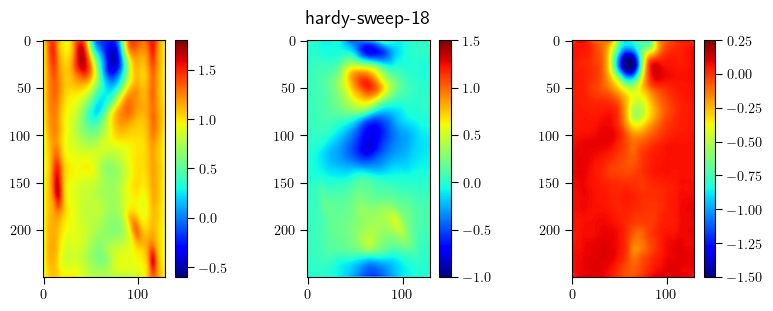

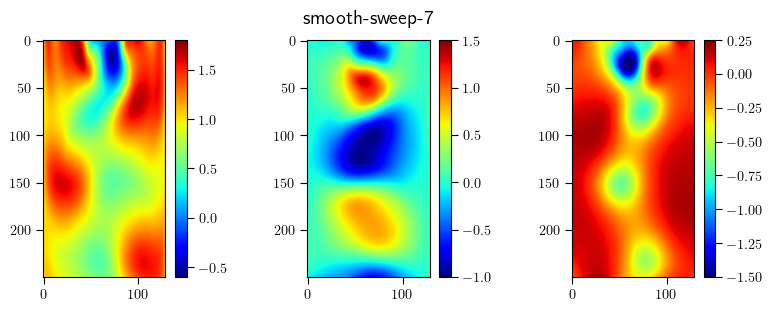

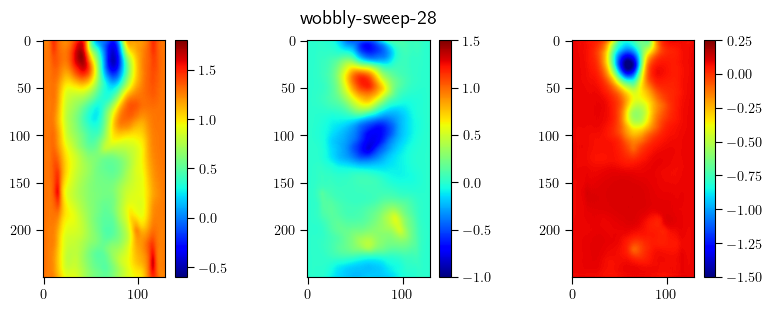

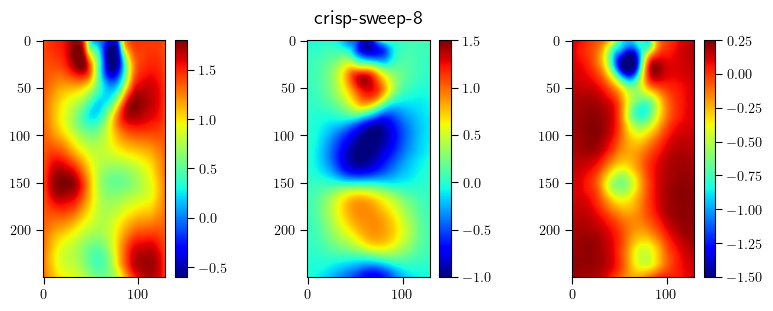

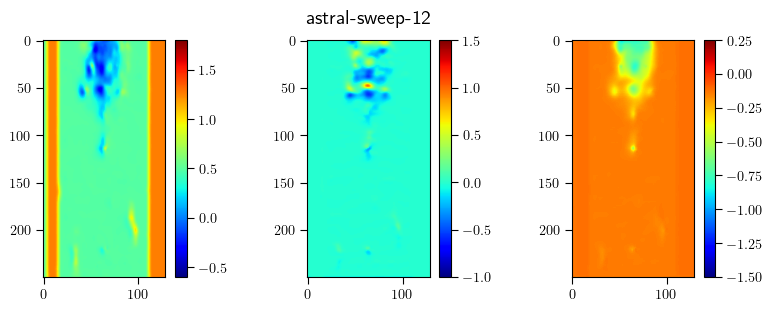

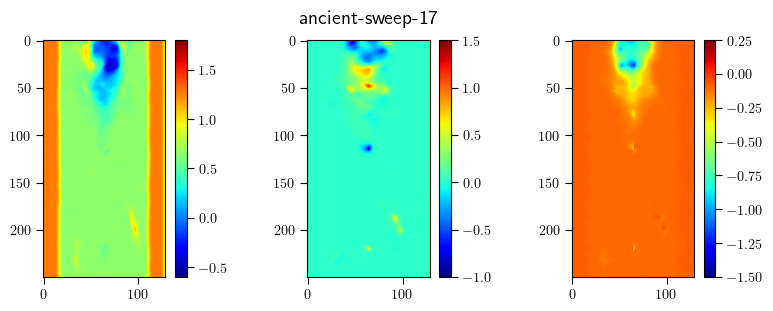

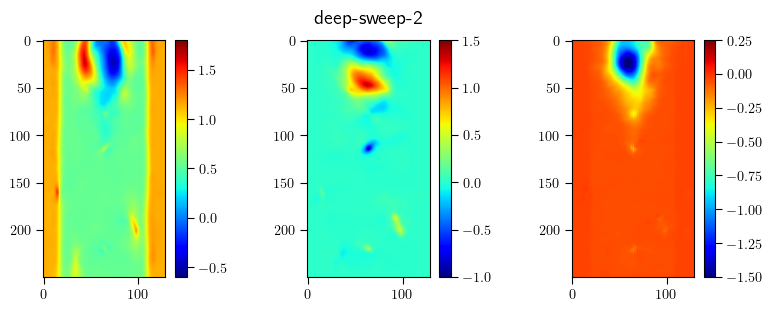

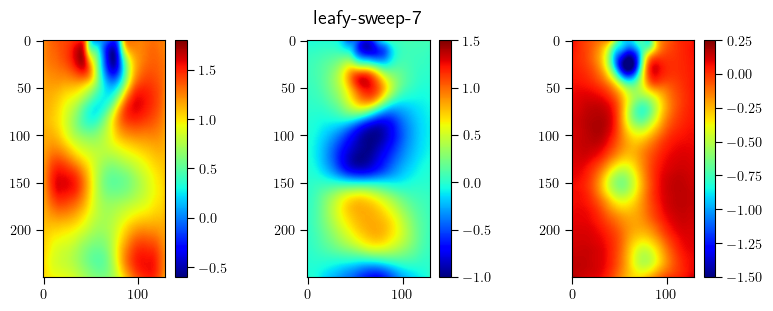

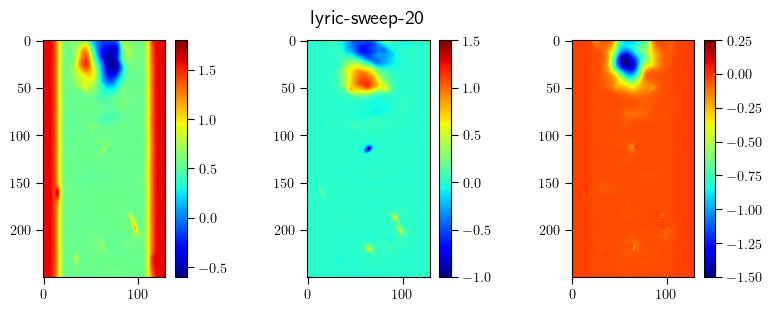

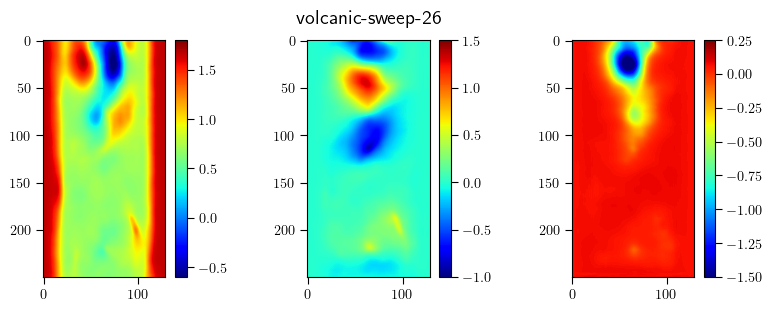

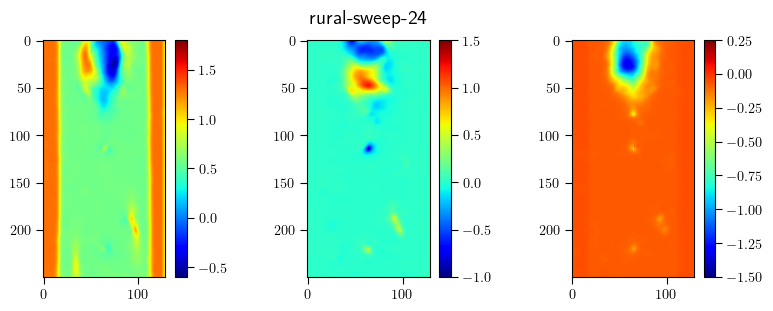

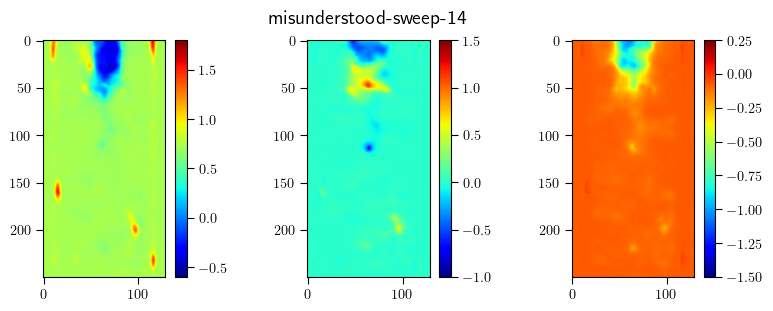

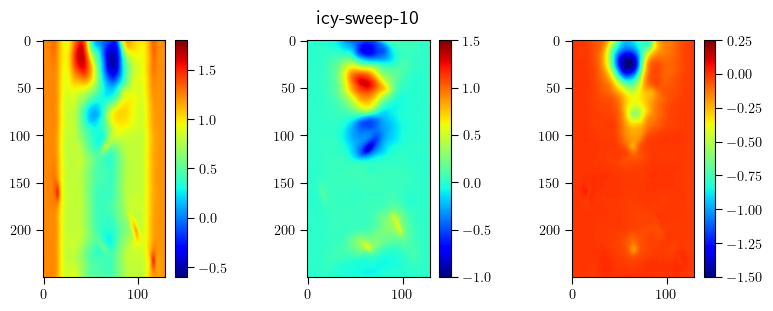

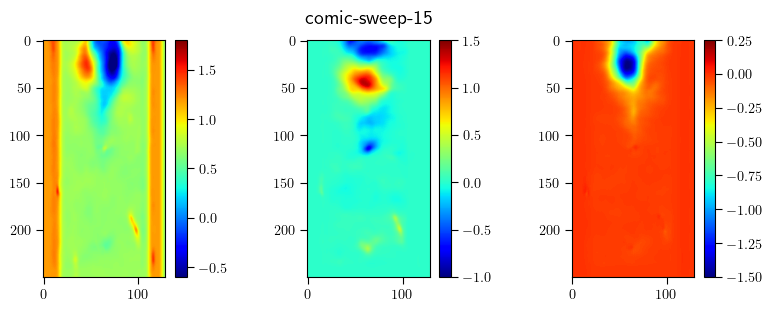

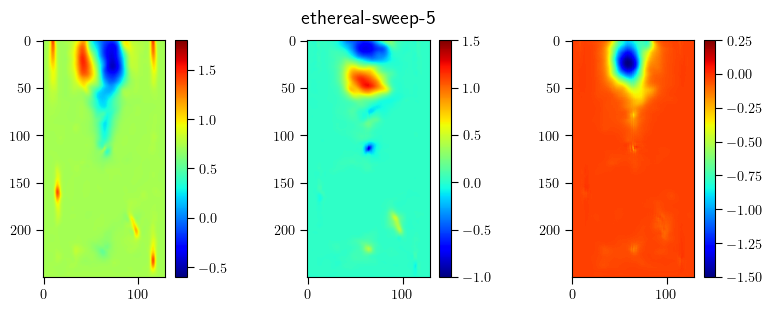

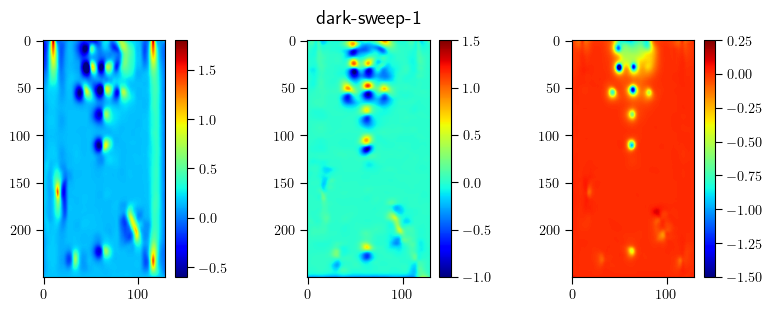

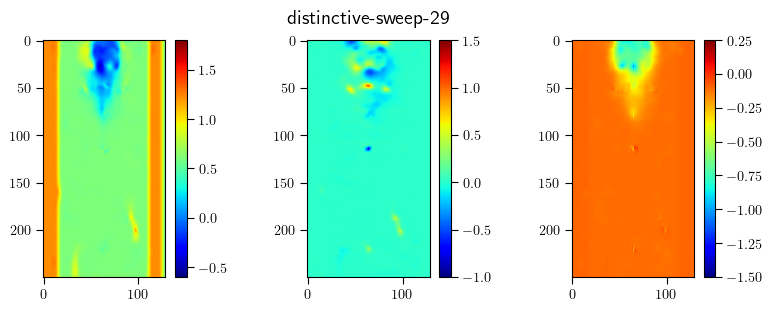

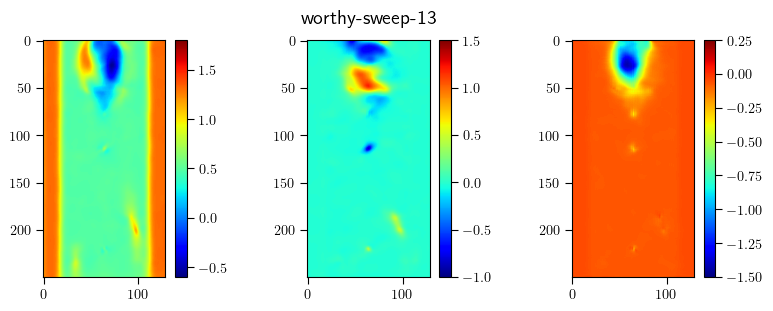

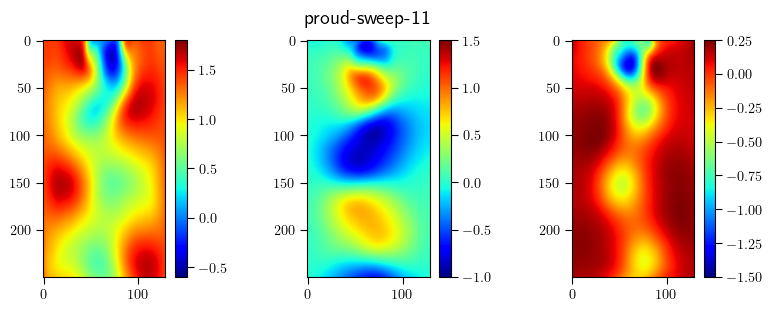

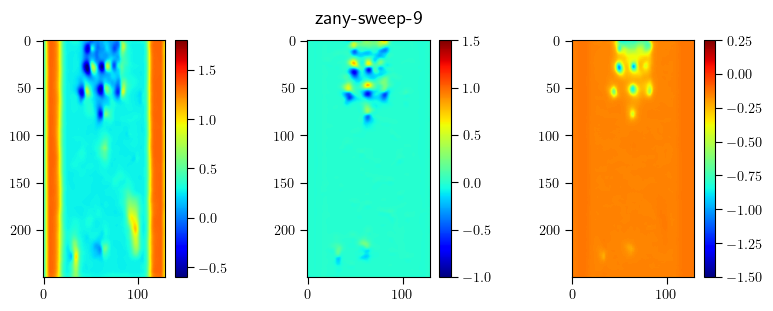

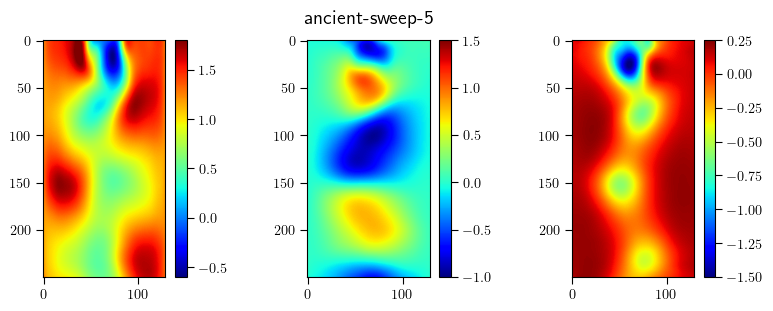

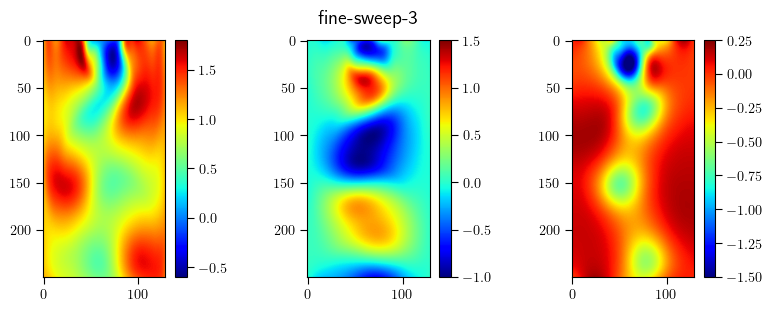

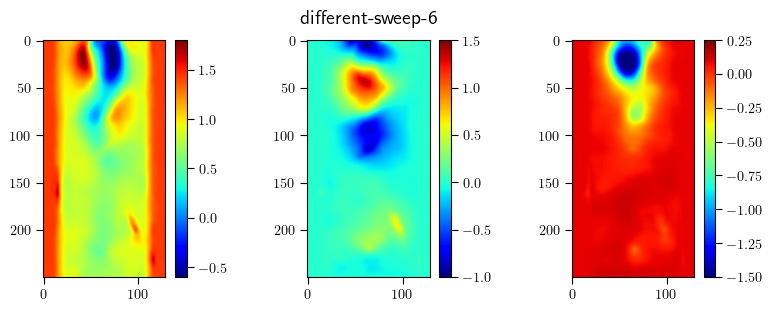

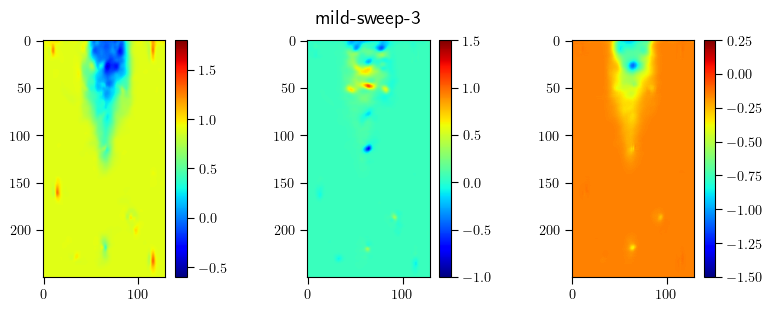

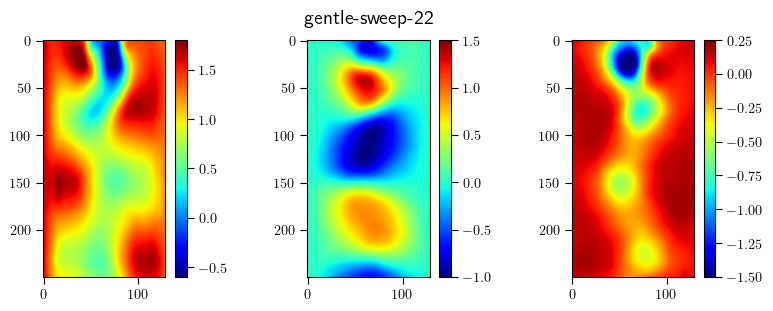

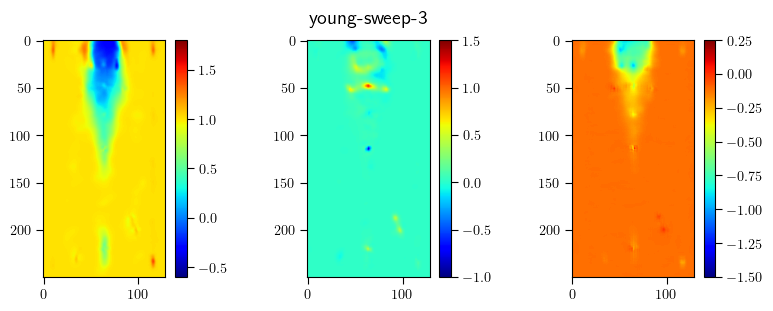

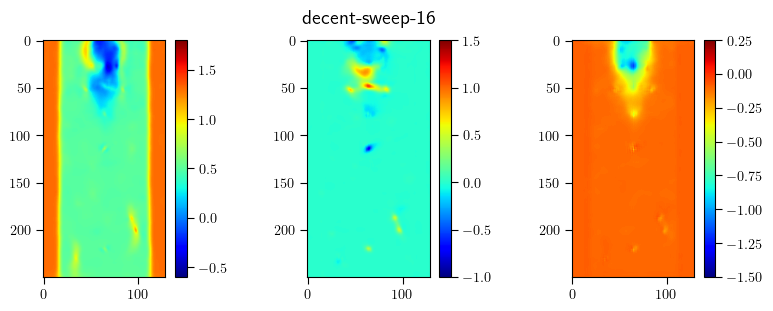

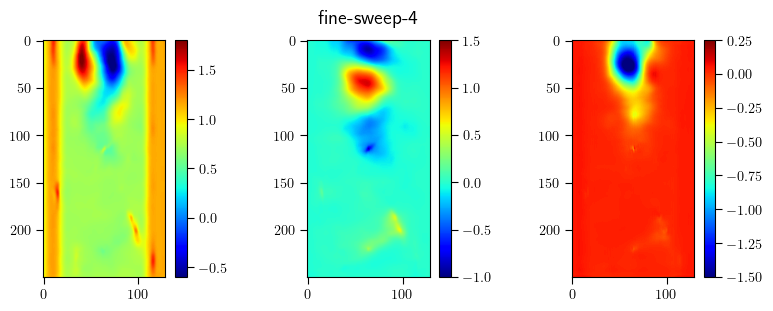

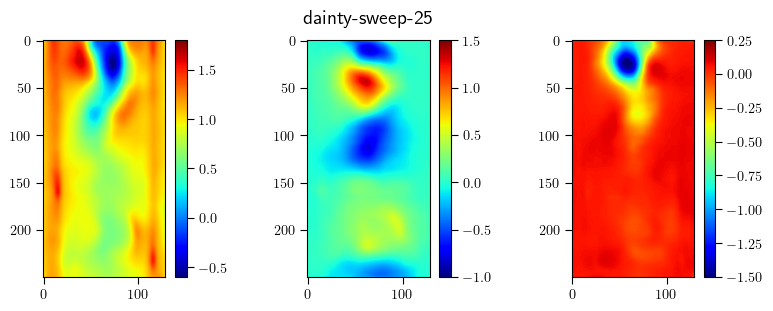

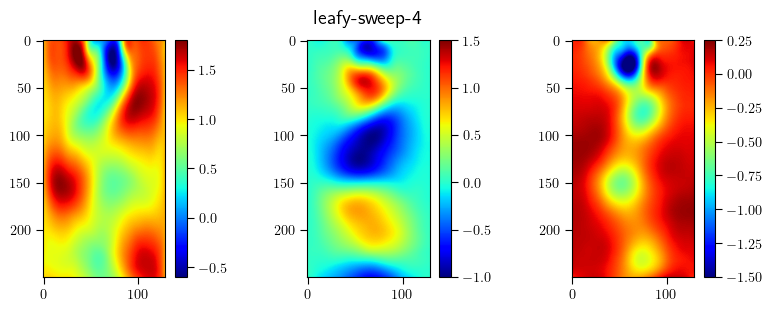

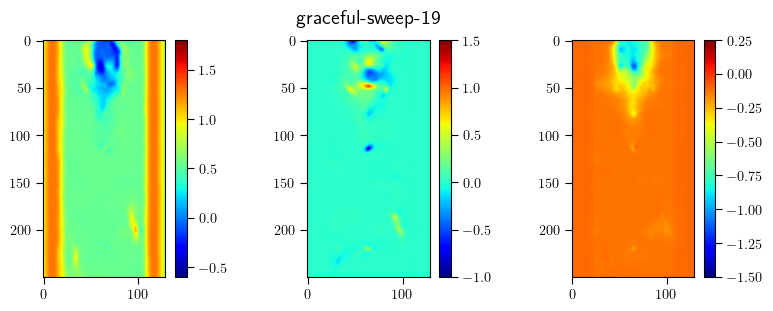

In [127]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("test3.pdf")

# for i in range(len(name_3)):
#     sweep_name = name_3[i]
#     results_dir = Path(sweep_dir_3,sweep_name)
#     with open(Path(results_dir,'config.yml'),'r') as f:
#         cfg = yaml.load(f, Loader=yaml.UnsafeLoader)

#     ## normalise
#     if cfg.data_config.normalise:
#         # [ux_train_normal,uy_train_normal,pp_train_normal], train_minmax = data_utils.normalise(ux_train,uy_train,pp_train)
#         [ux_val_normal,uy_val_normal,pp_val_normal], val_minmax = data_utils.normalise(ux_val,uy_val,pp_val)
#         # [ux_test_normal,uy_test_normal,pp_test_normal], test_minmax = data_utils.normalise(ux_test,uy_test,pp_test)
#         ## take input
#         # pb_train = simulation.take_measurement_base(pp_train_normal,ly=triangle_base_coords,centrex=0)
#         pb_val = simulation.take_measurement_base(pp_val_normal,ly=triangle_base_coords,centrex=0)
#         # pb_test = simulation.take_measurement_base(pp_test_normal,ly=triangle_base_coords,centrex=0)
#     else:
#         ## take input
#         # pb_train = simulation.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
#         pb_val = simulation.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
#         # pb_test = simulation.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

#     # pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
#     pb_val = np.reshape(pb_val,(cfg.data_config.train_test_split[1],-1))
#     # pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

#     # u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
#     u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
#     # u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)


#     state = state_utils.restore_trainingstate(results_dir,'state')
#     _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
#     mdl = make_model(cfg.model_config)
#     rng = jax.random.PRNGKey(10)
#     pred_val = mdl.apply(state.params,rng,pb_val,TRAINING=False)
#     if cfg.data_config.normalise:
#         pred_val = data_utils.unnormalise_group(pred_val, val_minmax, axis_data=-1, axis_range=0)
    

#     take_observation, _ = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_val[0,...],example_pin_snapshot=pb_val[0,...])
    
#     # l_s_val = losses.mse(take_observation(pred_val),take_observation(u_val))
#     # l_d_val = np.mean(derivatives.div_field(pred_val[...,:-1],datainfo)**2)
#     # l_m_val = np.mean(derivatives.momentum_residual_field(pred_val,datainfo)**2)
#     l_mse_clean = losses.relative_error(pred_val,u_val) 

#     fig,ax = plt.subplots(1,3,figsize=(8,3))
#     im1 = ax[0].imshow(pred_val[20,:,:,0],vmin=-0.6,vmax=1.8)
#     plt.colorbar(im1,ax=ax[0])
#     im2 = ax[1].imshow(pred_val[20,:,:,1],vmin=-1,vmax=1.5)
#     plt.colorbar(im2,ax=ax[1])
#     im3 = ax[2].imshow(pred_val[20,:,:,2],vmin=-1.5,vmax=0.25)
#     plt.colorbar(im3,ax=ax[2])
#     fig.suptitle(str(sweep_name))


# fig_nums = plt.get_fignums()  
# figs = [plt.figure(n) for n in fig_nums]
# for fig in figs: ## will open an empty extra figure :(
#     pdf.savefig(fig)
# pdf.close()

In [130]:
print(list(zip(name_3,loss_3[:,0])))
print(list(zip(name_classic,loss_classic[:,0])))

[('dashing-sweep-2', 0.42173177), ('helpful-sweep-23', 0.4573325), ('ethereal-sweep-6', 0.45024723), ('different-sweep-8', 0.06709607), ('expert-sweep-9', 0.433581), ('sunny-sweep-30', 0.4013359), ('curious-sweep-21', 0.5709878), ('dashing-sweep-27', 0.52727145), ('ancient-sweep-10', 0.46643505), ('hardy-sweep-18', 0.52977383), ('smooth-sweep-7', 0.055447906), ('wobbly-sweep-28', 0.598944), ('crisp-sweep-8', 0.409015), ('astral-sweep-12', 0.6040274), ('ancient-sweep-17', 0.51902515), ('deep-sweep-2', 0.49750242), ('leafy-sweep-7', 0.059926655), ('lyric-sweep-20', 0.5701436), ('volcanic-sweep-26', 0.50445956), ('rural-sweep-24', 0.5109182), ('misunderstood-sweep-14', 0.58003557), ('icy-sweep-10', 0.3824022), ('comic-sweep-15', 0.5370152), ('ethereal-sweep-5', 0.49853018), ('dark-sweep-1', 0.8847878), ('distinctive-sweep-29', 0.5473628), ('worthy-sweep-13', 0.5280186), ('proud-sweep-11', 0.67729175), ('zany-sweep-9', 0.6855508), ('ancient-sweep-5', 0.81363875), ('fine-sweep-3', 0.0462824